In [ ]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np
from keras.callbacks import EarlyStopping

In [42]:
print("Number of GPU: ", len(tf.config.experimental.list_physical_devices("GPU")))

Number of GPU:  1


In [43]:
image_width = 300
image_height = 300
batch = 8
channels = 3
train_size = 0.8
test_size = 0.1
epochs = 40

In [44]:
leafs_dataset = tf.keras.preprocessing.image_dataset_from_directory("D:\Medicinal Plant Identification\Indian Medicinal Leaves Image Datasets\Smaller Leaf dataset", shuffle=True, image_size=(image_width,image_height), batch_size=batch)

Found 1007 files belonging to 7 classes.


In [45]:
leafs_classes= leafs_dataset.class_names
# plant_classes = plants_dataset.class_names
n_classes = len(leafs_classes)
print(n_classes)
leafs_classes


7


['Aloevera', 'Bamboo', 'Coriender', 'Curry', 'Mint', 'Tamarind', 'Tulsi']

(8, 300, 300, 3)
[6 3 5 0 4 1 1 2]


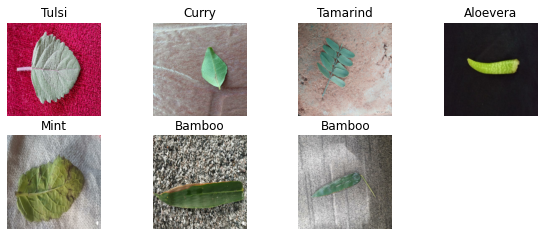

In [46]:
plt.figure(figsize=(10,10))
for image_batch, labels_batch in leafs_dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())
    for i in range (7):
        ax = plt.subplot(5,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(leafs_classes[labels_batch[i]])
        plt.axis('off')

In [47]:
print(len(leafs_dataset)*train_size)
print(len(leafs_dataset)*test_size)

100.80000000000001
12.600000000000001


In [48]:
def get_dataset(ds, train_split=0.7, val_split=0.15, test_split = 0.1, shuffle=True, shuffle_size=10000):
  #assert(train_split+val_split+test_split) == 1
  ds_size = len(ds)
  if shuffle:
    ds = ds.shuffle(shuffle_size,seed=12) 

  train_size = int(train_split*ds_size)
  valid_size = int(val_split*ds_size)
  leafs_train_dataset = ds.take(train_size)
  leafs_val_dataset = ds.skip(train_size).take(valid_size)
  leafs_test_dataset = ds.skip(train_size).skip(valid_size)
  
  return leafs_train_dataset, leafs_val_dataset, leafs_test_dataset

In [49]:
train_ds, val_ds, test_ds = get_dataset(leafs_dataset)

print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

88
18
20


In [50]:
train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [51]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1.0/255),
    layers.experimental.preprocessing.Resizing(image_width,image_height)
])


data_aug = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomContrast(0.2)
])

In [52]:
input_shape = (batch, image_width,image_height,channels)

model = models.Sequential([
    resize_and_rescale,
    data_aug,
    #convolutional layers
    layers.Conv2D(16, kernel_size=(3,3), activation = 'relu', input_shape = input_shape ),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32, kernel_size=(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32, kernel_size=(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32, kernel_size=(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32, kernel_size=(3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    #flattening layers
    layers.Flatten(),
    layers.Dense(32, activation = 'relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=input_shape)

In [53]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [54]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (8, 300, 300, 3)          0         
                                                                 
 sequential_5 (Sequential)   (None, 300, 300, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 298, 298, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 149, 149, 16)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 147, 147, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 73, 73, 32)       0         
 g2D)                                                 

In [55]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [25]:
history = model.fit(
    train_ds,
    batch_size = batch,
    validation_data = val_ds,
    verbose = 1,
    epochs = epochs
    # callbacks=[early_stopping]
)

88/88 [==============================] - 41s 228ms/step - loss: 1.9438 - accuracy: 0.1605 - val_loss: 1.9054 - val_accuracy: 0.1736
Epoch 2/40
88/88 [==============================] - 29s 202ms/step - loss: 1.8495 - accuracy: 0.2987 - val_loss: 1.8370 - val_accuracy: 0.2986
Epoch 3/40
88/88 [==============================] - 28s 202ms/step - loss: 1.7545 - accuracy: 0.3300 - val_loss: 1.5490 - val_accuracy: 0.4236
Epoch 4/40
88/88 [==============================] - 28s 201ms/step - loss: 1.6045 - accuracy: 0.3778 - val_loss: 1.5953 - val_accuracy: 0.3846
Epoch 5/40
88/88 [==============================] - 28s 200ms/step - loss: 1.4260 - accuracy: 0.4773 - val_loss: 1.5457 - val_accuracy: 0.4375
Epoch 6/40
88/88 [==============================] - 28s 198ms/step - loss: 1.3351 - accuracy: 0.5000 - val_loss: 1.3866 - val_accuracy: 0.5069
Epoch 7/40
88/88 [==============================] - 28s 199ms/step - loss: 1.2734 - accuracy: 0.5605 - val_loss: 1.3005 - val_accuracy: 0.5069
Epoch 8/40

In [31]:
scores = model.evaluate(test_ds)
scores

20/20 [==============================] - 14s 15ms/step - loss: 0.7143 - accuracy: 0.7925


[0.7142894864082336, 0.7924528121948242]

In [32]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

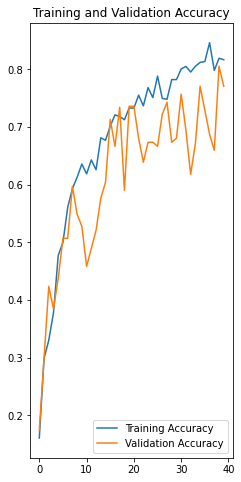

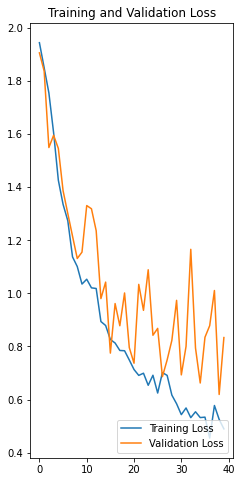

In [34]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(epochs), acc, label='Training Accuracy')
plt.plot(range(epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(epochs), loss, label='Training Loss')
plt.plot(range(epochs), val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

First image to predict
Actual Label:  Aloevera
1/1 [==============================] - 0s 421ms/step
Predicted Label:  Aloevera


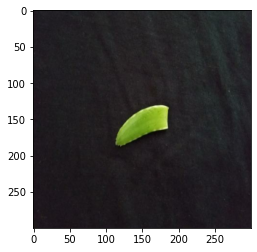

In [35]:
for image_batch, labels_batch in test_ds.take(1):
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("First image to predict")
    plt.imshow(first_image)
    print("Actual Label: ", leafs_classes[first_label])

    batch_prediction = model.predict(image_batch)
    print('Predicted Label: ',leafs_classes[np.argmax(batch_prediction[0])])
    confidence = round(100*(np.max(batch_prediction)))

In [38]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = leafs_classes[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 36ms/step


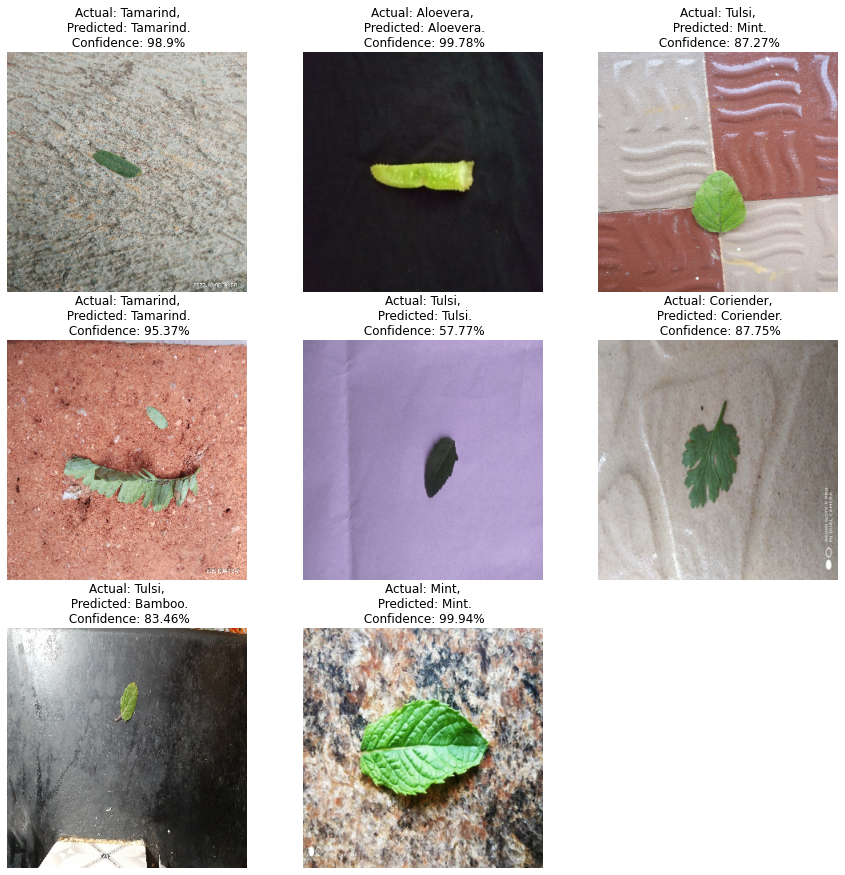

In [39]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(8):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class , confidence = predict(model, images[i].numpy())
        actual_class = leafs_classes[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [40]:
import os
model_version=max([int(i) for i in os.listdir("./Successful_Models") + [0]])+1
model.save(f"./Successful_Models/{model_version}")

INFO:tensorflow:Assets written to: ./Successful_Models/2\assets


INFO:tensorflow:Assets written to: ./Successful_Models/2\assets


In [41]:
model.save("./leafs_v6.h5")